# Assignment 03 - Auto-encoders and The U-net Model

This assignment is composed of two tasks:

1. Design an auto-encoder to denoise a simple image dataset composed of circles;

2. Implement the U-net model for signal denoising;

Each task corresponds to 50% of the final grade of the assignment. Teams with less than 4 people can choose to do just one of the tasks without any penalty. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. 
    - Name the notebook as enel645_assignment03_team_(team number).ipynb
2. The weights of your Auto-encoder and U-net models. 
    - Name the weights files as team_(team number)_autoencoder.h5 (task 01) and team_(team number)_unet.h5 (task 02)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page (two files if your team has less than 4 people)

You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code and your model explanation (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%

The data for this assignment can be downloaded here:
- [GDrive](https://drive.google.com/file/d/17XmiQ1lNOP28blGmTFv8Zf5cf08unGgV/view?usp=sharing)
- [OneDrive](https://uofc-my.sharepoint.com/:u:/g/personal/roberto_medeirosdeso_ucalgary_ca/EVe0Mh19GUBGp7qXOIaXRtIBYeJgBtBvc5ULFoT1svhudw?e=rVNREx) - Link expires March 8th, 2021. 

## 1. Denoising Auto-encoder

Develop an auto-encoders that receives as input a 96 x 96 noisy image with a circle of a radius R and outputs the corresponding denoised image. Make the dimensionality of your latent space as low as posisble without compromising the results of the denoised images.

- Justify the choice of your latent space dimension;
- The results will be assessed visually;  

# **** NOTE **** After cloning the repo you have to manually upload the 144mb train.npy to `"Data/Assignment03/AUTOENCODER/`

In [1]:
!git clone https://github.com/davisallan/enel645Team25Assignment3.git

Cloning into 'enel645Team25Assignment3'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 16), reused 11 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [2]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

In [3]:
# global variables
seed = 2021

### 1.1 Load data 

In [4]:
# Adapt the paths to your environment
X_train = np.load("/content/enel645Team25Assignment3/Data/Assignment03/AUTOENCODER/train.npy")[:,:,:,np.newaxis]
X_val = np.load("/content/enel645Team25Assignment3/Data/Assignment03/AUTOENCODER/val.npy")[:,:,:,np.newaxis]
X_test = np.load("/content/enel645Team25Assignment3/Data/Assignment03/AUTOENCODER/test.npy")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2000, 96, 96, 1)
(500, 96, 96, 1)
(20, 96, 96)


### 1.2. Explore your data 

In [5]:
# Function for plotting a random selection of 24 images from the dataset passed
def plot_images(dataset_name, dataset, numImages = 24, testSet=False):
  sample_indexes = np.random.choice(np.arange(dataset.shape[0], dtype = int),size = numImages, replace = False)
  plt.figure(figsize=(24,18))
  
  if testSet:
    images = dataset
  else:
    images = dataset[:,:,:,0]

  for i in range(numImages):
      plt.subplot(5, 8, i + 1)
      plt.imshow(images[sample_indexes[i]], cmap = "gray")
      plt.axis("off")
      plt.title("Index = " + str(sample_indexes[i]))
  plt.suptitle("Random sampling of Images from " + dataset_name)
  plt.show()


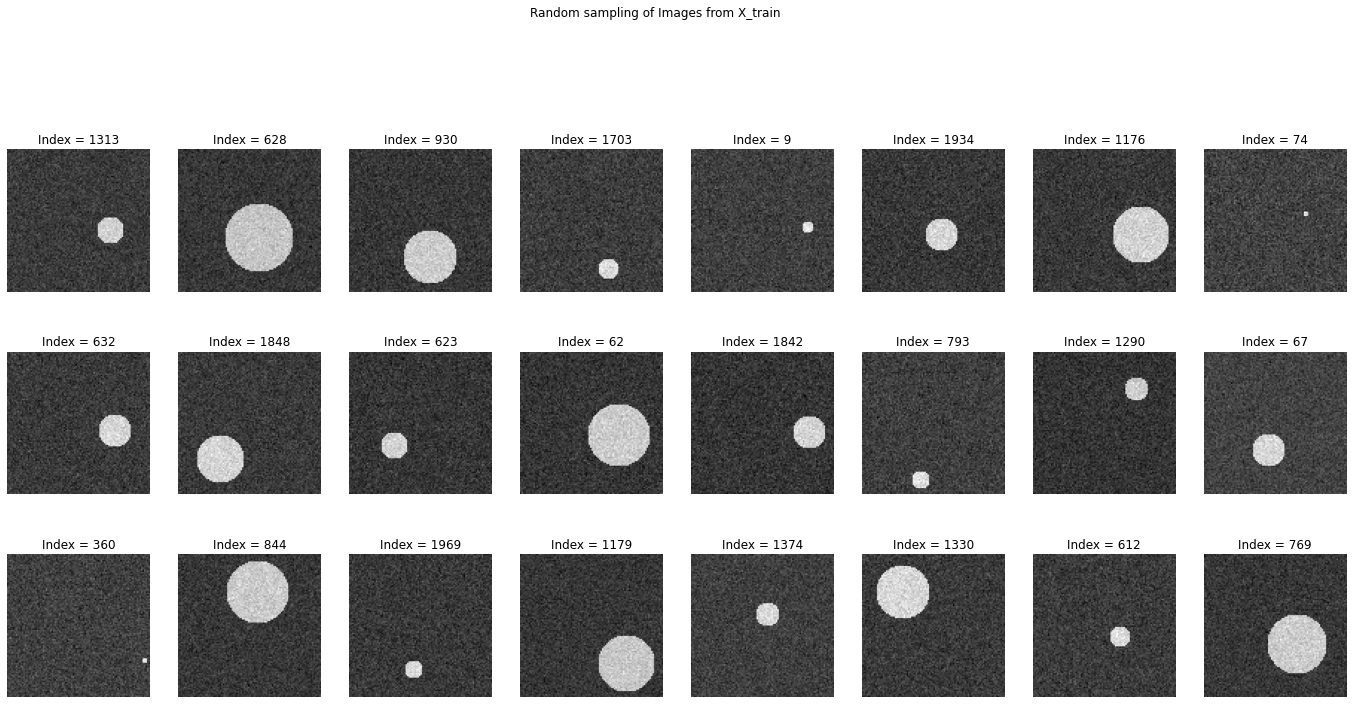

In [6]:
# plot a random sampling of 24 images from the training dataset
plot_images("X_train", X_train)

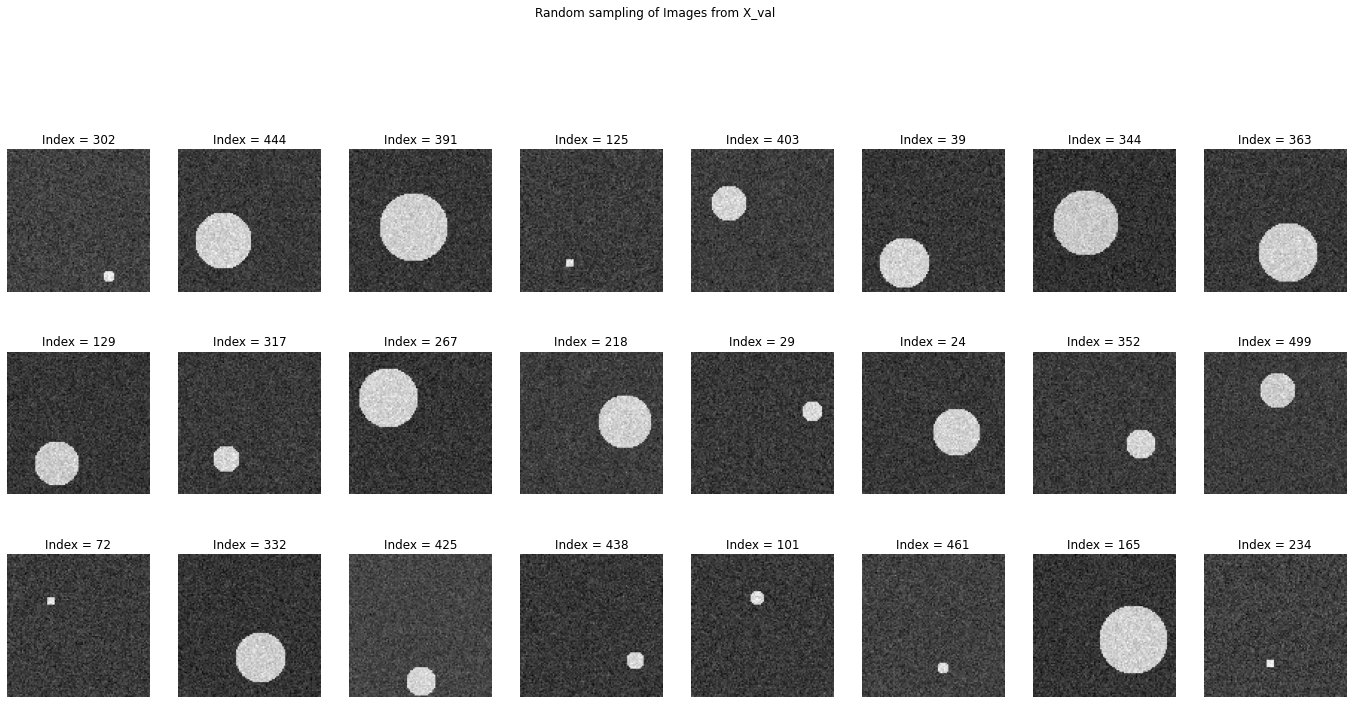

In [7]:
# plot a random sampling of 24 images from the validation dataset
plot_images("X_val", X_val)

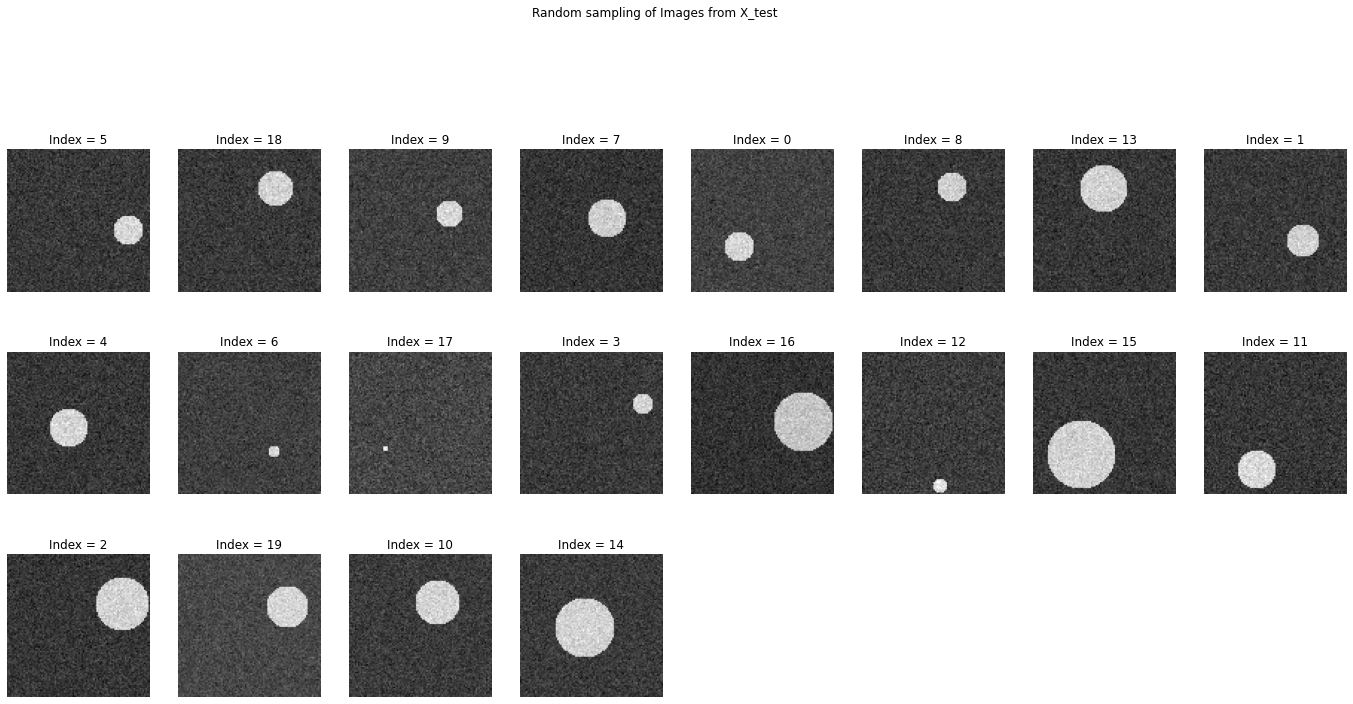

In [8]:
# plot all 20 images from the test set
plot_images("X_test", X_test, 20, True)

### 1.3. Data scaling and Data augmentation

#### 1.3.1 Data Scaling

In [9]:
# Data scaling
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

#### 1.3.2 Data Augmentation

In [ ]:
# Definitely just guessing with these parameters for the time being
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=35, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             horizontal_flip=True, 
                             vertical_flip=True)

In [ ]:
X_train_augmented = datagen.flow(X_train, seed = seed)
X_val_augmented = datagen.flow(X_val, seed = seed)

### 1.4. Define your  model, cost function, optimizer, learning rate

In [38]:
# Define your model here. 
def my_autoencoder(ishape = (96,96,1),ndim = 1000, lr = 1e-4):
  input_img = tf.keras.layers.Input(shape = ishape)
  c1 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', strides= (2,2))(input_img)
  c2 = tf.keras.layers.Conv2D(64, (4,4), activation= 'relu', strides= (2,2))(c1)
  c3 = tf.keras.layers.Conv2D(128, (4,4), activation= 'relu', strides= (2,2))(c2)
  c4 = tf.keras.layers.Conv2D(256, (4,4), activation= 'relu', strides= (2,2))(c3)
  flat = tf.keras.layers.Flatten()(c4)
  d1 = tf.keras.layers.Dense(ndim)(flat)
  encoder = tf.keras.models.Model(inputs = input_img, outputs = d1)
  input_decoder = tf.keras.layers.Input(shape = (ndim))
  d2 = tf.keras.layers.Dense(6*6*256)(input_decoder)
  reshaped_img = tf.keras.layers.Reshape((6,6,256))(d2)
  up1 = tf.keras.layers.UpSampling2D((2,2))(reshaped_img)
  c5 = tf.keras.layers.Conv2D(128, (4,4), activation= 'relu', padding= 'same')(up1)
  up2 = tf.keras.layers.UpSampling2D((2,2))(c5)
  c6 = tf.keras.layers.Conv2D(64, (4,4), activation= 'relu', padding= 'same')(up2)
  up3 = tf.keras.layers.UpSampling2D((2,2))(c6)
  c7 = tf.keras.layers.Conv2D(32, (4,4), activation= 'relu', padding= 'same')(up3)
  up4 = tf.keras.layers.UpSampling2D((2,2))(c7)
  c8 = tf.keras.layers.Conv2D(1, (4,4), activation= 'relu', padding= 'same')(up4)
  decoder = tf.keras.models.Model(inputs= input_decoder, outputs= c8)
  autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoder(encoder(input_img)))
  autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = "mse")
  return encoder,decoder,autoencoder

In [39]:
encoder, decoder, autoencoder = my_autoencoder()

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 47, 47, 32)        544       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 22, 22, 64)        32832     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 10, 10, 128)       131200    
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 4, 4, 256)         524544    
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              409

### 1.5. Define your callbacks (save your model, patience, etc.)

In [40]:
model_name_autoencoder = "team_25_autoencoder.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_autoencoder, monitor='val_loss',
                                             verbose=0, save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

def scheduler(epoch, lr):
  if epoch%10 == 0:
    lr = lr/2
  return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
# define your callbacks
# remember that you need to save the weights of your best model!

### 1.6. Train your model

In [41]:
# train your model - decide for how many epochs
autoencoder.fit(X_train,X_train, batch_size = 16, epochs = 100, verbose=1, 
                callbacks= [early_stop, monitor, lr_schedule], validation_data=(X_val, X_val))

Epoch 1/100
125/125 [==============================] - 7s 50ms/step - loss: 1.0509e-06 - val_loss: 9.8710e-07
Epoch 2/100
125/125 [==============================] - 6s 47ms/step - loss: 9.6414e-07 - val_loss: 9.2763e-07
Epoch 3/100
125/125 [==============================] - 6s 47ms/step - loss: 9.4865e-07 - val_loss: 8.8094e-07
Epoch 4/100
125/125 [==============================] - 6s 47ms/step - loss: 8.4309e-07 - val_loss: 7.8293e-07
Epoch 5/100
125/125 [==============================] - 6s 47ms/step - loss: 7.0213e-07 - val_loss: 5.9547e-07
Epoch 6/100
125/125 [==============================] - 6s 47ms/step - loss: 5.7758e-07 - val_loss: 5.1218e-07
Epoch 7/100
125/125 [==============================] - 6s 47ms/step - loss: 5.0818e-07 - val_loss: 4.7411e-07
Epoch 8/100
125/125 [==============================] - 6s 47ms/step - loss: 4.5722e-07 - val_loss: 4.4421e-07
Epoch 9/100
125/125 [==============================] - 6s 47ms/step - loss: 4.3421e-07 - val_loss: 4.2403e-07
Epoch 10/1

### 1.7. Test your model

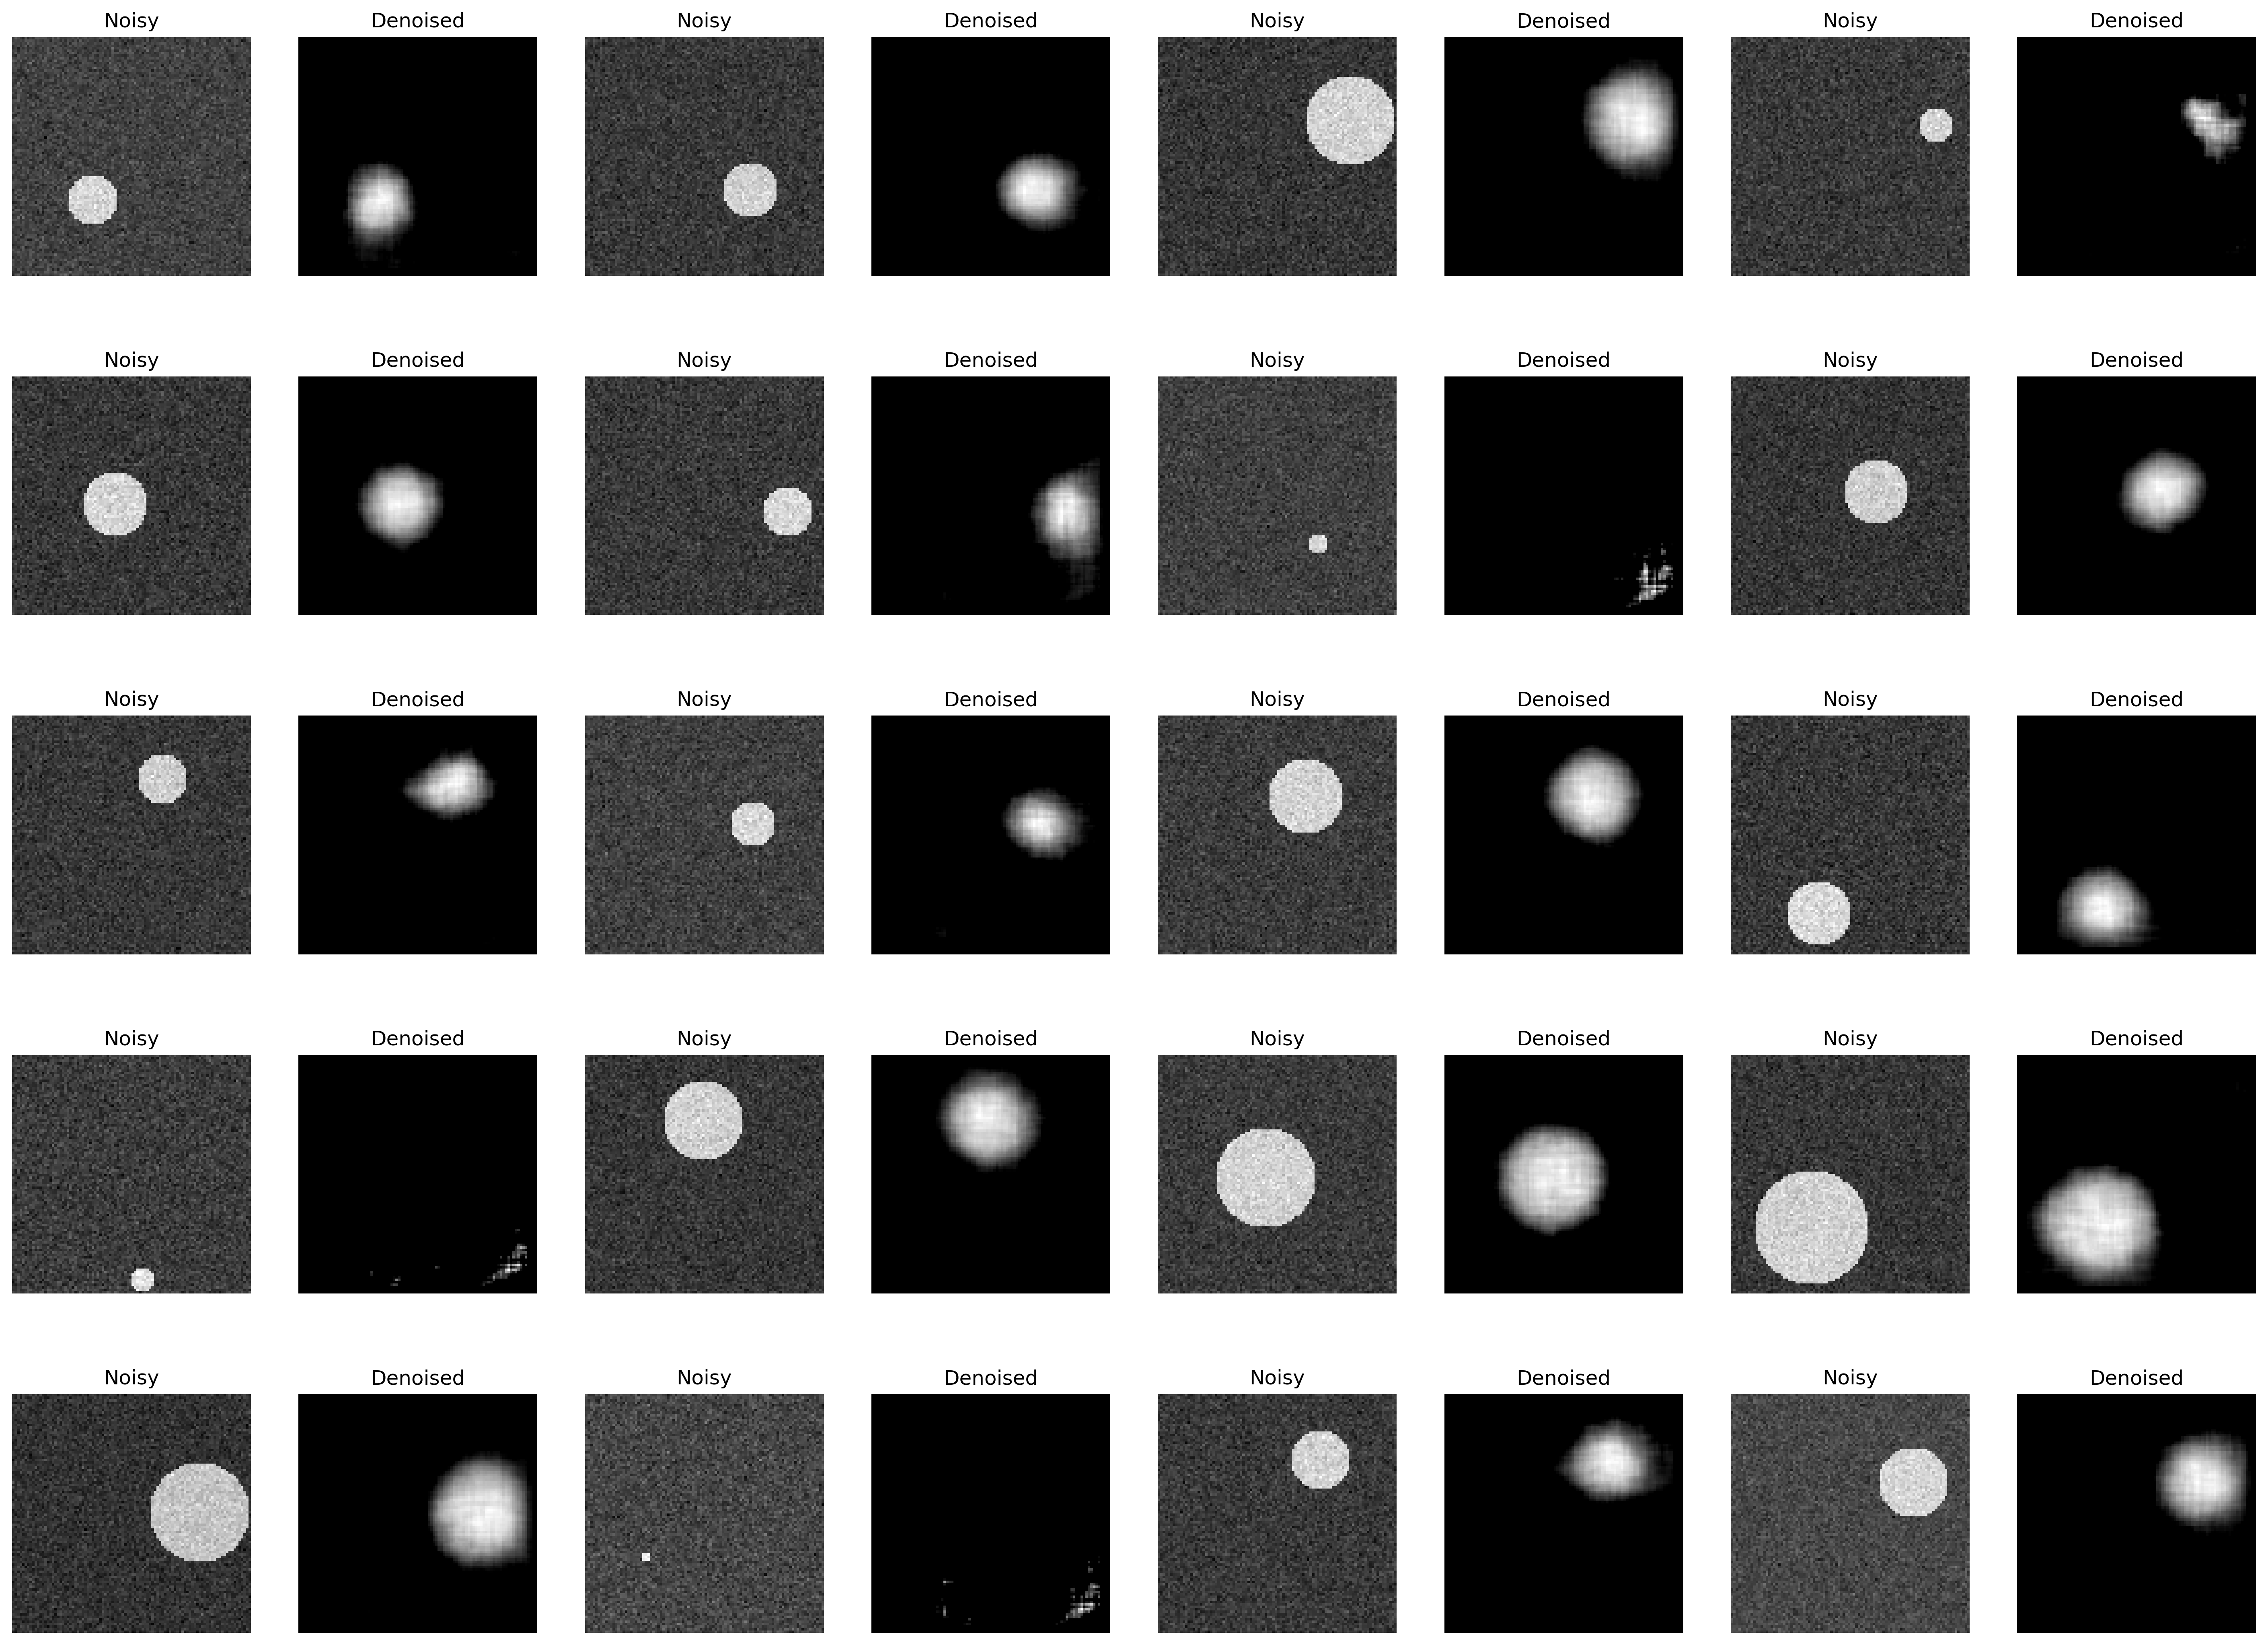

In [42]:
autoencoder.load_weights(model_name_autoencoder)
Xpred = autoencoder.predict(X_test)[:,:,:,0]

# Remember to "unscale your data".


#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(20):
    plt.subplot(5,8,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(5,8,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Denoised")
plt.show()

## 2. Denoising U-net

Develop an U-net model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

The mean squared error (MSE) of your U-net model should be lower than the MSE of just averaging the noisy measurements. 

- The results will be assessed using mean squared error. 

### 2.1 Load data  and split into train, validation, test

In [ ]:
data = np.load("/content/enel645Team25Assignment3/Data/Assignment03/UNET/noisy_transients.npy")
target = np.load("/content/enel645Team25Assignment3/Data/Assignment03/UNET/reference.npy")
indexes = np.arange(data.shape[0], dtype = int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]
X_train2 = data[:int(data.shape[0]*0.8)]
Y_train2 = target[:int(data.shape[0]*0.8)]

X_val2 = data[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]
Y_val2 = target[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]

X_test2 = data[int(data.shape[0]*0.9):]
Y_test2 = target[int(data.shape[0]*0.9):]

print(X_train2.shape)
print(X_val2.shape)
print(X_test2.shape)

### 2.2. Explore your data

In [ ]:
# Use this space to explore you datasets
# Create additional cells as you see fit

### 2.3. Data scaling and Data augmentation

In [ ]:
# Experiment with different data scaling methods

# Use data augmentation if you think it makes sense...

### 2.4. Define your  model, cost function, optimizer, learning rate

In [ ]:
# Define your model here. 
def my_unet(ishape = (256,20),lr = 1e-3):

    return model

### 2.5. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name_unet = "team_(team number)_unet.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

### 2.6. Train your model

In [ ]:
# train your model - decide for how many epochs

### 2.7. Test your model

In [ ]:
#model.load_weights(model_name_unet)
Ypred = model.predict(X_test2)[:,:,0]

Ymean = X_test2.mean(axis = -1)


# Remember to "unscale your data".


print("Unet MSE:")
print(((Ypred - Y_test2)**2).mean())
print("Mean MSE:")
print(((Ymean - Y_test2)**2).mean())


#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6,5,ii+1)
    plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Ymean[ii], label = "Mean")
    plt.plot(Ypred[ii], label = "UNET")
    plt.plot(Y_test2[ii], label = "Target")
    plt.legend()
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Arya Stark** helped design the model and write the code for fully connected model (**score 3**)
- **Luke Skywalker** helped design helped to implement the data augmentation module (**score 3**)
- ...